<img src="https://www.tu-darmstadt.de/media/resources/images_1/tu_logo_web.svg" width="200">

# FB18 Elektrotechnik und Informationstechnik

## Data Science 1 - Final Project

* **Name:** Augustine Maada Gbondo
* **Matriculation number :** 2331706
* **Course :** MSc. Tropical Hydrogeology and Environmental Engineering

## 1. Introduction

**Objective :** To predict the ambient `electrical energy output (PE)` of a `Combined Cycle Power Plant (CCCP)`
Ambients is a set of routinely collected measurements

**Societal and Economic benefits:**  Predicting the ambient `electrical energy output (PE)` of a CCCP is essential in measuring the effeciciency and providing energy for the community

**The Dataset:** Will be extracted at <a href="https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant">Link</a>. Features are explained at the next section of the notebook

**Problem statement:** The ambient `electrical energy output (PE)` of a CCCP is essential in regulating a power plant working at full load. This is required to preventing disasters and energy savings.

In [1]:
# importing standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## 2. Downloading the dataset
___

In [2]:
# importing web scrapping modules
import requests
from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup

In [3]:
# download the dataset as zip file from web directory
import requests

downloadUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'

req = requests.get(downloadUrl)
filename = req.url[downloadUrl.rfind('/')+1:]

with open(filename, 'wb') as f:
    for chunk in req.iter_content(chunk_size=9000):
        if chunk:
            f.write(chunk)

In [4]:
#importing modules to read the downloaded zipfile dataset
import zipfile
import os

os.listdir()

['.ipynb_checkpoints',
 'CCPP',
 'CCPP.zip',
 'data.png',
 'final_CCPP_model_PR.joblib',
 'Gbondo_2331706_Final_project.ipynb',
 'README.md']

In [5]:
# extract zipfile to folder
with zipfile.ZipFile('CCPP.zip') as f:
    f.extractall()

In [6]:
# reading a specific sheet in zipfile
## openpyxl is used for manipulating xcel data
from openpyxl import Workbook, load_workbook

# load in the workbook
xl_data = pd.ExcelFile('CCPP/Folds5x2_pp.xlsx')

#The dataset is in the xcell format with 5 sheets, for this project, Sheet5 was used
df = xl_data.parse('Sheet5')

# read the data
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


### About the Dataset
The dataset contains 9568 data points collected from a <a href="https://en.wikipedia.org/wiki/Combined_cycle_power_plant">Combined Cycle Power Plant</a> over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables `Temperature (T)`, `Ambient Pressure (AP)`, `Relative Humidity (RH)` and `Exhaust Vacuum (V)` to predict the net hourly `electrical energy output (PE)` of the plant.

#### Functionality of a CCPP
A combined cycle power plant (CCPP) is composed of `gas turbines (GT)`, `steam turbines (ST)` and `heat recovery steam generators`. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

#### Data Processing
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in `.ods` and in `.xlsx` formats.
____

#### Attribute Information:

Features consist of hourly average ambient variables
- `Temperature (T)` in the range 1.81°C and 37.11°C,
- `Ambient Pressure (AP)` in the range 992.89-1033.30 milibar,
- `Relative Humidity (RH)` in the range 25.56% to 100.16%
- `Exhaust Vacuum (V)` in the range 25.36-81.56 cm Hg
- `Net hourly electrical energy output (PE)` 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

## 3. Exploratory Data Analysis

<u>Descriptive statistics:</u>

`.mean()`, `.median()`, `.mode()`, `.min()`, `.max()`, `.var()`, `.std()`

In [7]:
## Statistics of dataset
print('The shape of the data is: ', df.shape)
df.describe().T

The shape of the data is:  (9568, 5)


,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [8]:
# exploring the target variable (Net hourly electrical energy output (PE))
print(' The mean of PE is: ', df.PE.mean())
print(' The median of PE is: ', df.PE.median())
print(' The lowest value of PE is: ', df.PE.min())
print(' The highest value of PE is: ', df.PE.max())
print(' The variance of PE is: ', df.PE.var())

 The mean of PE is:  454.3650094063547
 The median of PE is:  451.54999999999995
 The lowest value of PE is:  420.26
 The highest value of PE is:  495.76
 The variance of PE is:  291.28231832331363


In [9]:
## checking data type and presence of null values
df.info()
df.isnull().sum()  #The dataset is complete with no null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

#### Exploring relationship in dataset
<u>For a quick exploration, display a pairplot of `data`</u>

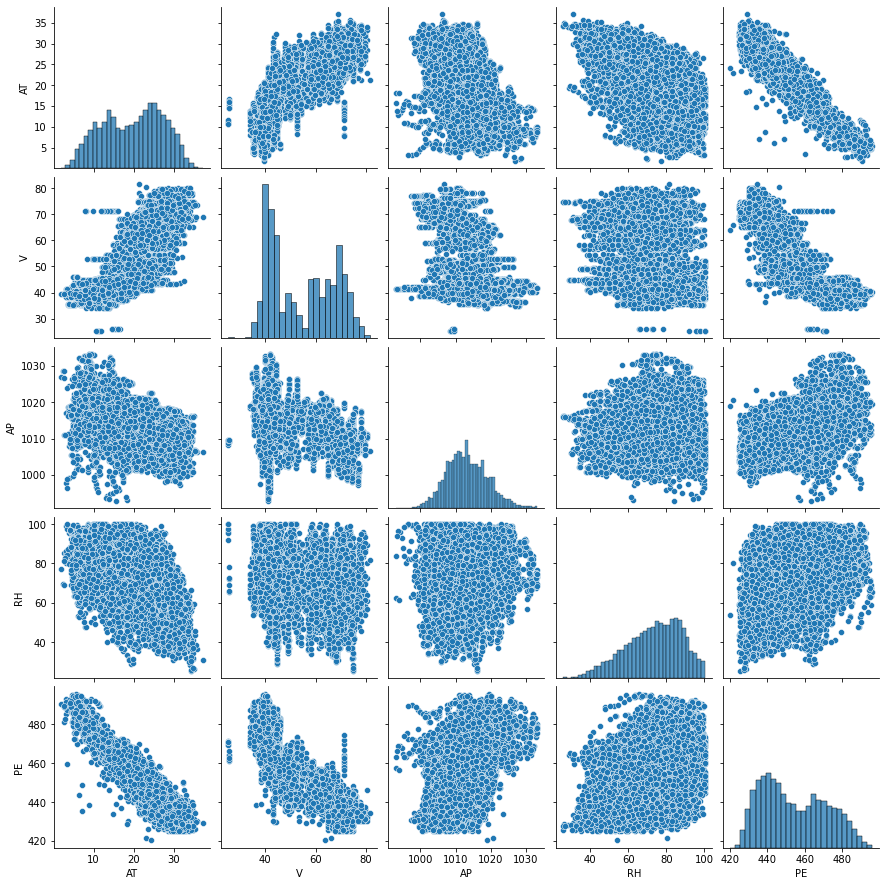

In [10]:
# Use pairplot from seaborn module
sns.pairplot(df)
plt.savefig('data.png')
plt.show()

#### comments
There seems to be a strong negative correlation between `PE` and features `AT` and `V`

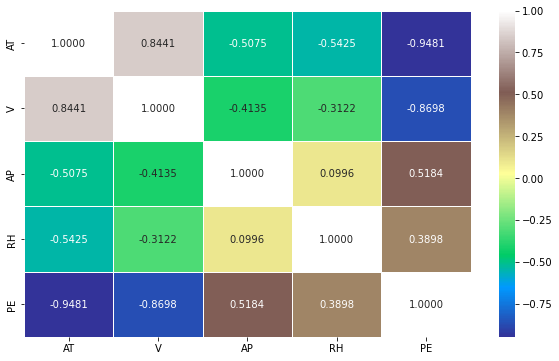

In [8]:
## Heatmap plot for correlation
sns.heatmap(df.corr(), annot=True,
            cmap='terrain',linewidth=.5, fmt=".4f")
fig= plt.gcf()
fig.set_size_inches(10,6)
plt.show()

#### comments
`PE` shows strong negative correlation with `V` and `AT`

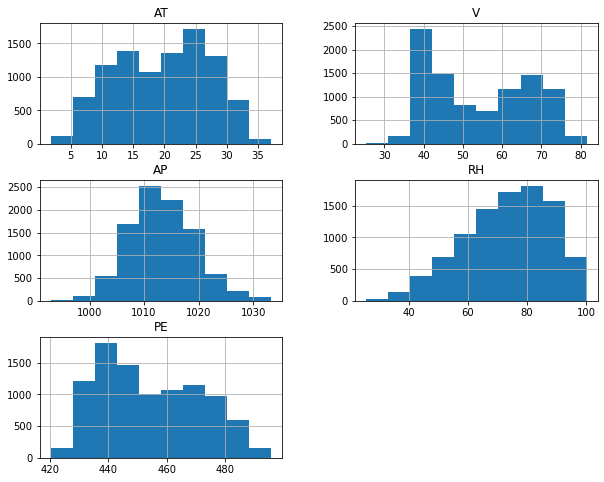

In [12]:
### ploting histograms
df.hist(figsize=(10,8))
plt.show()

<AxesSubplot:>

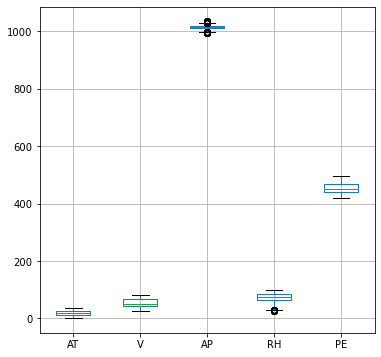

In [13]:
## boxplots to investigate outliers
df.boxplot(figsize=(6,6))

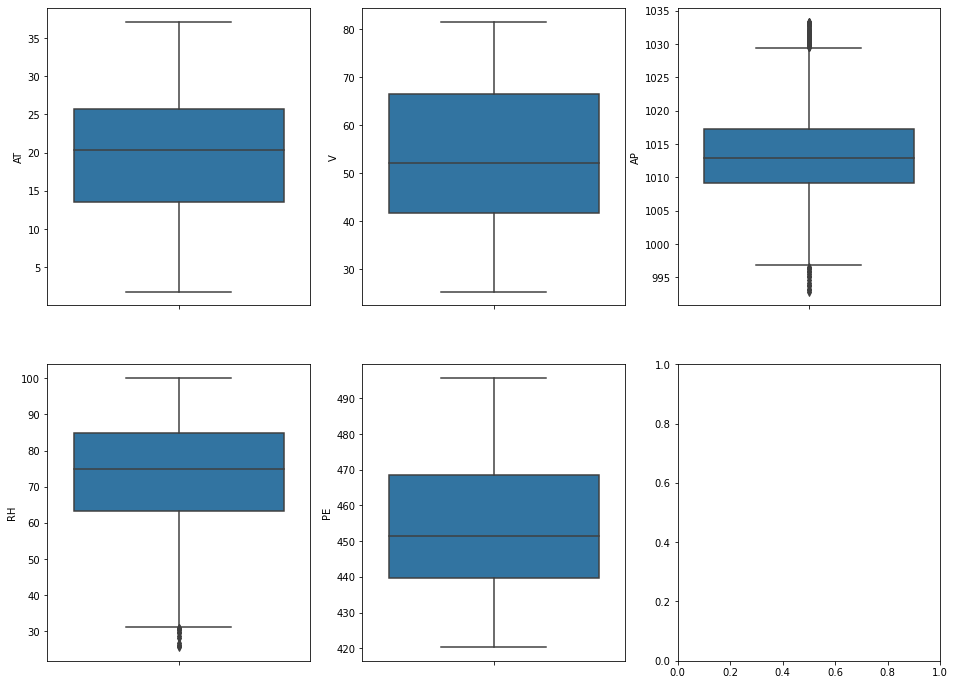

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=2,
                       figsize = (16,12))
ax = ax.flatten()
index = 0
for cols, values in df.items():
    sns.boxplot(y=cols, data=df, ax=ax[index])
    index +=1     

#### comments
The dataset is without outliers

## 4. Hypothesis Testing

Since the model is a multiple linear regression, we test for their suitability as a predictor of the target variable `PE`. The correlation coeff of `0.39` shows that `RH` seems like a weak predictor variable.

In general, the interpretation of a slope in multiple regression can be tricky. Correlations among the predictors can change the slope values dramatically from what they would be in separate simple regressions.
_____

Question: Does `RH` help us predict or explain the `PE`?
___

The equation for the Multiple linear regression can be written as:
$$y=\beta_0 + \beta_1 x_1 + \beta_1 x_1 + \beta_2 x_2 + \varepsilon$$


#### Null Hypothesis $H_0$
* `RH` is NOT a suitable predictor to explain `PE`

If the null hypothesis above were the case, then a change in the value of `RH` would have little or no effect on $y$ (PE), so $y$ and $x_1$ are not linearly related (taking into account $x_2$ and $x_3$)
* $H_0$ : $\beta1 = 0$

#### Alternate Hypothesis $H_1$ 
* `RH` is a suitable predictor to explain `PE`

If the alternate hypothesis above were the true, then a change in the value of `RH` have a significant effect on $y$
* $H_0$ : $\beta1 \neq 0$


<u> Hence we can write that

From the MLR equation:
$$y=\beta_0 + \beta_1 x_1 + \beta_1 x_1 + \beta_2 x_2 + \varepsilon$$

* Assign $\beta_1$ as `RH`
* Level of significance $\alpha$ = 0.05
* degree of plausibility $p$-value = ?

In [14]:
## Determining the p-value from OLS model
import statsmodels.formula.api as smf

#seperating dependent and independent variables#
## n/b PE = dependent variable, RH = independent variable##
RegHyp = 'PE ~ RH' 

## Fit the reg_line to the data
RegHypoutput= smf.ols(RegHyp, df).fit()

# print summary
print(RegHypoutput.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.152     
Dependent Variable: PE               AIC:                79870.6055
Date:               2023-06-07 16:32 BIC:                79884.9378
No. Observations:   9568             Log-Likelihood:     -39933.   
Df Model:           1                F-statistic:        1714.     
Df Residuals:       9566             Prob (F-statistic): 0.00      
R-squared:          0.152            Scale:              247.05    
--------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
Intercept   420.9618    0.8227  511.6762  0.0000  419.3491  422.5745
RH            0.4557    0.0110   41.3987  0.0000    0.4341    0.4772
-------------------------------------------------------------------
Omnibus:              772.278       Durbin-Watson:          1

#### conclusion
* From the test above, the $p$-value is 0.000, which is less than the $p$-value of the significant level of 0.05. Hence we reject the $H_0$ and accept $H_1$
* This test also conclude that despite the low correlation coeff. of `RH`, it is still a useful predictor for `PE`

## 5. Models

### 5.1. Linear Regression between PE and AT (Exploratory model)

<u>The Numpy function `polyfit` gives the least squares polynomial fit. With the degree 1, it solves the simple linear regression problem.</u>

In [15]:
## choose features for simple Linear Regression ------------------------------- LR_1
x1 = df['AT']
y1 = df['PE']

# Find the estimates of w1 and w0 at first order (linear)
w1,w0 = np.polyfit(x1,y1,1)

# print out the estimates
w1,w0

(-2.1713199585178007, 497.0341198927668)

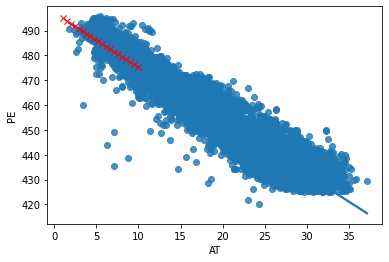

In [16]:
# With the following new data points:
xnew = np.linspace(1,10,20)

# Find the prediction yhat
ynew = xnew*w1 + w0

# use regplot in seaborn to plot x and y and the linear regression line
# on the same figure, plot the new estimated data points
sns.regplot(x=x1,y=y1)
plt.plot(xnew, ynew, 'rx')
plt.show()

We will now calculate the performance of the simple linear model using the metrics 
1. Mean absolute error (MAE)
2. Mean squared error (MSE)
3. Root mean squared error (RMSE)

In [17]:
# calculate the estimated y values using x and the estimated parameters
yhat = x1*w1 + w0

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

# Complete the following and print the results
mae_SLR = mae(y1, yhat)
mse_SLR = mse(y1, yhat)
rmse_SLR = mse(y1, yhat, squared=False)
print("MAE:", mae_SLR)
print("MSE:", mse_SLR)
print("RMSE:", rmse_SLR)

MAE: 4.287981894101461
MSE: 29.431702011093524
RMSE: 5.4250992627871355


### 5.2 Polynomial Regression (Exploratory)

We will still use one feature `AT`, and see if increasing the complexity of the model improves our prediction.

Consider the 2nd degree polynomial model $$ y=w_{2}x^{2}+w_{1}x+w_{0}+\varepsilon $$ where $x$ is the feature `AT`. We can estimate the parameters using the polyfit function in Numpy.

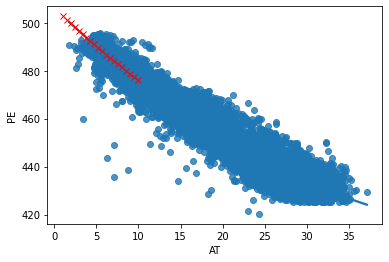

In [18]:
# Estimate w0, w1, and w2 using the polyfit function
# then estimate the house prices from the same RM = xnew 
w2,w1,w0 = np.polyfit(x1,y1,2)

ynew = w2*xnew**2 + w1*xnew + w0

# Using regplot in seaborn to plot x and y and 
# on the same figure, plot the new estimated data points
sns.regplot(x=x1,y=y1,order=2)
plt.plot(xnew, ynew, 'rx')
plt.show()

In [19]:
# MAE, MSE, and RMSE of the ploynomial-regression
yhat = w2*x1**2 + w1*x1 + w0
mae_PR = mae(y1, yhat)
mse_PR = mse(y1, yhat)
rmse_PR = mse(y1, yhat, squared=False)
print("MAE:", mae_PR)
print("MSE:", mse_PR)
print("RMSE:", rmse_PR)

MAE: 4.084613057312412
MSE: 27.03422439175241
RMSE: 5.199444623395119


## Train-test split and model selection

Executing a data split to simulate an unknown data set to report the performance of our model.

* Implement a 80-20 training-test split 
* Include all 4 features. 
* Specify the `random_state` for reproducibility, e.g. `random_state=123`. 

In [20]:
# import module for model simulation
from sklearn.model_selection import train_test_split

# Checking the shape of the original dataset
print(' The shape of the original data is: ', df.shape)

# Creating target and predictor variables from the DataFrame:
X = df.drop('PE', axis=1)
y = df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=123)

# checking the shape of the training dataset
print(' The shape of the training data is: ', X_train.shape)

 The shape of the original data is:  (9568, 5)
 The shape of the training data is:  (7654, 4)


In [21]:
## visualizing first 5 columns of training dataset
X_train.head(5)

,AT,V,AP,RH
2678,31.90,69.40,1003.40,57.76
370,26.39,71.25,999.80,89.12
6951,23.04,63.86,1019.83,59.78
1562,19.83,39.39,1013.73,59.16
6993,19.19,63.31,1016.88,66.58


In [22]:
## visualizing first 5 columns of Target dataset
# checking the shape of X-train, X_test, y_test, y_train datasets
print(' The shape of X_train data is: ', X_train.shape)
print(' The shape of X_test data is: ', X_test.shape)
print(' The shape of y_train data is: ', y_train.shape)
print(' The shape of y_test data is: ', y_test.shape)

 The shape of X_train data is:  (7654, 4)
 The shape of X_test data is:  (1914, 4)
 The shape of y_train data is:  (7654,)
 The shape of y_test data is:  (1914,)


### 5.3 Multiple Linear Regression
####  5.3.1 Multiple Linear Regression (trained_test)

In [23]:
## Model_1 
## training model 1
model_1=LinearRegression()
model_1.fit(X_train,y_train)

# making prediction of the model
y_pred=model_1.predict(X_test)
print(y_pred)

[445.461495   481.22472352 436.84322429 ... 477.64155499 438.31479672
 429.93332633]


In [24]:
X_test.shape

(1914, 4)

In [25]:
# predicting PE for a particular set of predictor variables
model_1.predict([[14.96,41.76,1024.07,73.17]])

array([467.25440426])

#### 5.3.2 Multiple Linear Regression (Polynomial)
* Training a model with 6 degrees of polynomial features

In [26]:
from sklearn.preprocessing import PolynomialFeatures



# creating empty list to store rmses
train_rmses = []
test_rmses = []

# iterating over 1-5 order polynomials
for d in range(1,6):    
    # new features with degree "d"
    poly_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = poly_converter.fit_transform(X)
    
    # SPLIT THIS NEW POLY DATA SET
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, 
                                                        test_size=0.2, random_state=123)
    
    # TRAIN ON THIS NEW POLY SET
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate Errors
    # Errors on Train Set
    train_RMSE = np.sqrt(mse(y_train,train_pred))
    
    # Errors on Test Set
    test_RMSE = np.sqrt(mse(y_test,test_pred))

    # Append errors to lists for plotting later    
   
    train_rmses.append(train_RMSE)
    test_rmses.append(test_RMSE)
    

In [27]:
print('The train RMSES are: ', train_rmses)
print('The test RMSES are: ', test_rmses)

The train RMSES are:  [4.537980453280844, 4.24583967456359, 4.138288420525145, 4.075440503026644, 3.99766532175421]
The test RMSES are:  [4.633399504512061, 4.292851398179797, 4.199423831922967, 4.130851707299344, 4.092031176051741]


In [28]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,21.09,67.07,1004.38,89.01,444.7881,1414.5063,21182.3742,1877.2209,4498.3849,67363.7666,...,6.048689e+12,5.360460e+11,4.750538e+10,4.210014e+09,1.022093e+15,9.057973e+13,8.027342e+12,7.113978e+11,6.304538e+10,5.587197e+09
1,7.24,41.17,1020.35,80.56,52.4176,298.0708,7387.3340,583.2544,1694.9689,42007.8095,...,3.523285e+12,2.781750e+11,2.196284e+10,1.734038e+09,1.105976e+15,8.732048e+13,6.894240e+12,5.443230e+11,4.297610e+10,3.393105e+09
2,28.62,70.32,1008.87,46.67,819.1044,2012.5584,28873.8594,1335.6954,4944.9024,70943.7384,...,3.369941e+12,1.558924e+11,7.211531e+09,3.336031e+08,1.045144e+15,4.834801e+13,2.236563e+12,1.034627e+11,4.786151e+09,2.214058e+08
3,22.73,66.75,1018.13,84.06,516.6529,1517.2275,23142.0949,1910.6838,4455.5625,67960.1775,...,5.921754e+12,4.889185e+11,4.036665e+10,3.332797e+09,1.093997e+15,9.032383e+13,7.457418e+12,6.157078e+11,5.083476e+10,4.197077e+09
4,14.93,41.79,1008.88,81.48,222.9049,623.9247,15062.5784,1216.4964,1746.4041,42161.0952,...,3.496568e+12,2.823927e+11,2.280683e+10,1.841944e+09,1.045196e+15,8.441295e+13,6.817428e+12,5.505948e+11,4.446759e+10,3.591328e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,24.39,51.86,1014.92,59.98,594.8721,1264.8654,24753.8988,1462.9122,2689.4596,52633.7512,...,3.251879e+12,1.921804e+11,1.135753e+10,6.712099e+08,1.076860e+15,6.364052e+13,3.761043e+12,2.222711e+11,1.313583e+10,7.763049e+08
1910,13.87,42.99,1007.45,81.52,192.3769,596.2713,13973.3315,1130.6824,1848.1401,43310.2755,...,3.583456e+12,2.899631e+11,2.346300e+10,1.898559e+09,1.037809e+15,8.397658e+13,6.795147e+12,5.498440e+11,4.449182e+10,3.600152e+09
1911,8.70,36.24,1013.34,89.50,75.6900,315.2880,8816.0580,778.6500,1313.3376,36723.4416,...,3.375023e+12,2.980881e+11,2.632767e+10,2.325307e+09,1.068503e+15,9.437213e+13,8.335116e+12,7.361723e+11,6.502005e+10,5.742687e+09
1912,25.16,74.33,1014.55,76.70,633.0256,1870.1428,25526.0780,1929.7720,5524.9489,75411.5015,...,5.953603e+12,4.500925e+11,3.402700e+10,2.572442e+09,1.074898e+15,8.126231e+13,6.143433e+12,4.644436e+11,3.511195e+10,2.654464e+09


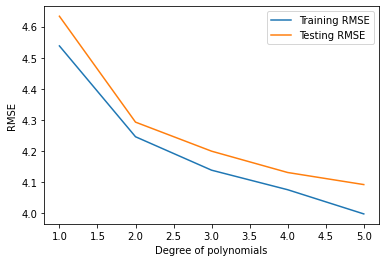

In [29]:
plt.plot(range(1,6), train_rmses, label="Training RMSE")
plt.plot(range(1,6), test_rmses, label="Testing RMSE")
plt.ylabel("RMSE")
plt.xlabel("Degree of polynomials")
plt.legend()
plt.show()

Training final model with optimal $a$ value

In [30]:
##creating sub dataset
predictor = df.drop('PE', axis=1)
Target = df['PE']

# Train the final model with the whole dataset
final_model_PR = LinearRegression(fit_intercept=False)

poly_converter = PolynomialFeatures(degree=2,include_bias=False)
poly_features = poly_converter.fit_transform(predictor)

final_model_PR.fit(poly_features, Target)

print(final_model_PR.intercept_)
print(final_model_PR.coef_)

0.0
[-1.52329128e+01 -1.93236463e+00  1.08851596e+00  1.76393366e+00
  1.94208640e-02  1.11748400e-02  1.22364430e-02 -4.32460832e-03
 -1.23033435e-03  1.50817504e-03  2.41364755e-04 -5.73245412e-04
 -1.53699628e-03 -1.73951521e-03]


In [31]:
# Saving the model
from joblib import dump, load
dump(final_model_PR, 'final_CCPP_model_PR.joblib')

['final_CCPP_model_PR.joblib']

In [32]:
# Loading the model
loaded_final_PR_model = load('final_CCPP_model_PR.joblib')
loaded_final_PR_model.coef_

array([-1.52329128e+01, -1.93236463e+00,  1.08851596e+00,  1.76393366e+00,
        1.94208640e-02,  1.11748400e-02,  1.22364430e-02, -4.32460832e-03,
       -1.23033435e-03,  1.50817504e-03,  2.41364755e-04, -5.73245412e-04,
       -1.53699628e-03, -1.73951521e-03])

#### 5.3.3 LASSO and RIDGE Regression

##### Feature Scaling, Cross Validation , and Regularization

It is necessary to standardize variables before using `Lasso` and `Ridge Regression`.

* Feature scaling is important to avoid features with high values being given higher weights
* Equation : $\left\Vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{w}\right\Vert ^{2}+\alpha\left|\boldsymbol{w}\right|^{2}$

In [33]:
X.shape, y.shape

((9568, 4), (9568,))

In [34]:
# uSING StandardScaler from sklearn for the feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fitting the training data to avoid data leakage
scaler.fit(X_train)

# Scale the training and test features
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### 5.3.3 a. Ridge Regression

In [35]:
from sklearn.linear_model import Ridge

In [36]:
# Alpha is a hyperparameter
## cross validation is used to find the optimal value
model_ridge = Ridge(alpha=10) 

# Fitting the training set
model_ridge.fit(scaled_X_train, y_train)

# Prediction on the test set
test_pred = model_ridge.predict(scaled_X_test)

# Print the MSE
print('MSE: ', mse(y_test, test_pred))
print('RMSE: ', mse(y_test, test_pred, squared=False))

MSE:  18.221057087569594
RMSE:  4.268613016843949


Deciding $\alpha$ by cross validation

In [37]:
# import Ridge regression Cross Validation 
from sklearn.linear_model import RidgeCV

# Trying different alpha values
model_ridgecv = RidgeCV(alphas=(0.1,1.0,10.0))

#from sklearn.metrics import SCORERS
#SCORERS.keys()
model_ridgecv.fit(scaled_X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [38]:
model_ridgecv.alpha_

0.1

In [39]:
# Fit the training set
model_ridgecv.fit(scaled_X_train, y_train)

# Prediction on the test set
test_pred = model_ridgecv.predict(scaled_X_test)

# Print the MSE
print('MSE: ', mse(y_test, test_pred))
print('RMSE: ', mse(y_test, test_pred, squared=False))

MSE:  17.516752625875426
RMSE:  4.18530197547028


In [40]:
model_ridgecv.coef_

array([-15.34326604,  -9.28021623,  16.07587346,   4.2725971 ,
        -5.81771516,  -0.90091189,  -9.10137273,  -9.08045857,
         2.27533774,  -3.27688553, -12.12730543,   8.34075589,
         0.63061884,  20.88912547,   3.82118798,   5.47025067,
        -0.47396414,  -8.08228155,   9.61354846,  -2.47742428,
         1.94165892,  -3.08865266,  -2.6055784 ,  -1.53399247,
        11.22824284,  -1.09464109,  -1.28240033,   2.55815917,
        -3.4655129 ,  -7.73894546,   0.31213314,  -3.27949249,
        12.66637624,  14.49575413, -10.81391369,  12.24723094,
         3.48859742,   9.71161461,   1.89321227,  -1.89258001,
         2.29996067,   4.81429942,   0.49015384, -14.44646209,
         7.42013929,  -2.05346828,  10.28404765,  -4.13492464,
         4.48673425,  -1.4416422 ,   2.67310655,   3.61773913,
        -1.43339608,   0.94032007,  12.25929008,  -1.38248057,
         4.95570082,  -4.52207542,   1.30100316,  -7.71509818,
         8.1888646 ,   5.10867155,  -4.65263277,  -2.84

#### 5.3.3 b. LASSO Regression

In [41]:
## import Lasso cross validation
from sklearn.linear_model import LassoCV

# assign model name
model_lassocv = LassoCV()

#fit model to lassoCV
model_lassocv.fit(scaled_X_train, y_train)

# print the optimum alpha value of the lasso regression
print('The optimum alpha is: ', model_lassocv.alpha_)

The optimum alpha is:  0.01616005188698661


In [42]:
# Prediction on the test set
test_pred = model_lassocv.predict(scaled_X_test)

# Print the MSE and RMSE
print('MSE: ', mse(y_test, test_pred))
print('RMSE: ', mse(y_test, test_pred, squared=False))

MSE:  18.71155952062897
RMSE:  4.325686017342101


In [43]:
model_lassocv.coef_

array([-1.50203927e+01, -2.78674019e+00,  5.20372057e-01, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -7.21641786e-01,
       -3.04315631e-01, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.14556085e-01,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

## 6. Model performance

 The R2 score of the simple MLR is:  0.9270312819720488


Text(0.5, 1.0, 'Simple MLR model')

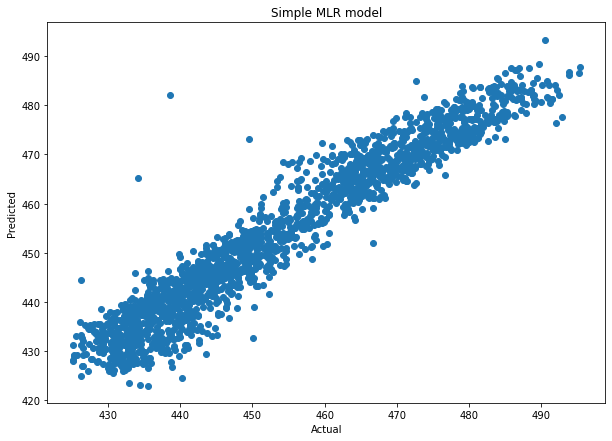

In [44]:
## MLR
from sklearn.metrics import r2_score
print( ' The R2 score of the simple MLR is: ', r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.xlabel ('Actual')
plt.ylabel ('Predicted')
plt.title('Simple MLR model')

 The R2 score of the Ridge regression is:  0.9364014512064311


Text(0.5, 1.0, 'Ridge Regression Model')

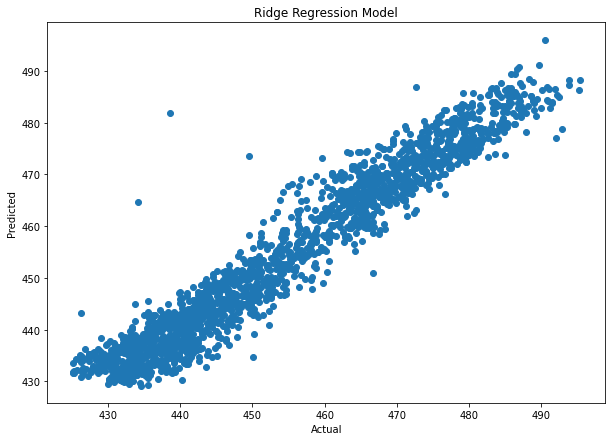

In [45]:
## Ridge regression
print( ' The R2 score of the Ridge regression is: ', r2_score(y_test, test_pred))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(y_test, test_pred)
plt.xlabel ('Actual')
plt.ylabel ('Predicted')
plt.title('Ridge Regression Model')

## 7. Conclusion

* Ridge Regression was the most accurate model with `MSE: 17.517` and `RMSE:  4.185` and an $r^2$ : 0.936. However, this does not show a significant difference from the simple MLR with $r^2$ of 0.92

* The model shows that `Temperature (AT)`, `Ambient Pressure (AP)`, `Relative Humidity (RH)` and `Exhaust Vacuum (V)` are good predictors for the net hourly `electrical energy output (PE)` of the plant. In short we can infer that there is a linear relationship between the above named predictors and the target. 

* Despite the efficiency of the model, it is limited in predicting values within the time span of the data, therefore any data outside the time period is not certain to be predicted with the accuracately. 

* Machine Learning applications in the energy sector is important as it reduces cost of continous supervision and parameters can be predicted within appreciable accuracy levels.

## References:

1. Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, [Web Link].
([Web Link])

2. Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

3. Dataset: https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

4. OLS details: https://www.youtube.com/watch?v=6biU48ZAx3o

5. Data Science 1 course: Fachbereich Elektrotechnik und Informationstechnik- TU Darmstadt